In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Importing datasets

In [2]:
dataset=pd.read_csv('eorDat.csv')
dataset.head()

,Country,EOR_Method,Porosity,Permiability,Depth,Gravity,Viscocity,Temperature,Oil_Saturation,Project_Eval,Profit
0,USA,Polymer,14.0,40.0,4800.0,34.0,2.63,102.0,50.0,succ,No
1,Norway,Steam Injection,31.0,205.0,1200.0,19.0,32.00,105.0,57.0,Disc.,No
2,USA,CO2 Injection,23.0,30.0,2680.0,40.0,1.00,82.0,60.0,Disc.,No
3,USA,CO2 Injection,16.0,20.0,4500.0,41.0,1.10,97.0,35.0,Disc.,good
4,USA,CO2 Injection,18.0,2.0,5400.0,42.0,0.40,104.0,39.0,Disc.,good


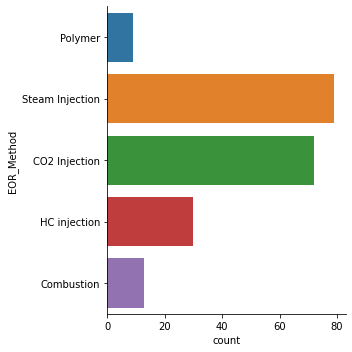

In [3]:
sns.catplot(y="EOR_Method",data=dataset,kind='count')

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203 entries, 0 to 202
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         203 non-null    object 
 1   EOR_Method      203 non-null    object 
 2   Porosity        203 non-null    float64
 3   Permiability    203 non-null    float64
 4   Depth           203 non-null    float64
 5   Gravity         203 non-null    float64
 6   Viscocity       203 non-null    float64
 7   Temperature     203 non-null    float64
 8   Oil_Saturation  203 non-null    float64
 9   Project_Eval    203 non-null    object 
 10  Profit          203 non-null    object 
dtypes: float64(7), object(4)
memory usage: 17.6+ KB


In [5]:
dataset.rename(columns={'Permeability':'Permiability'},inplace=True)

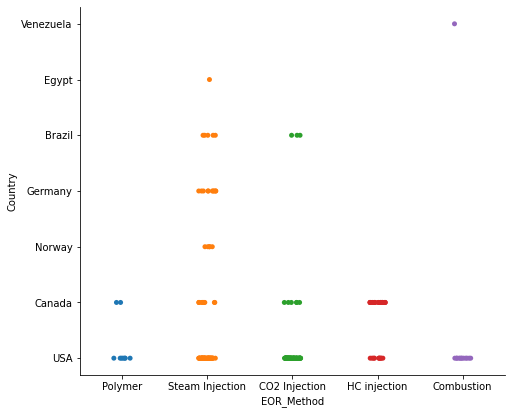

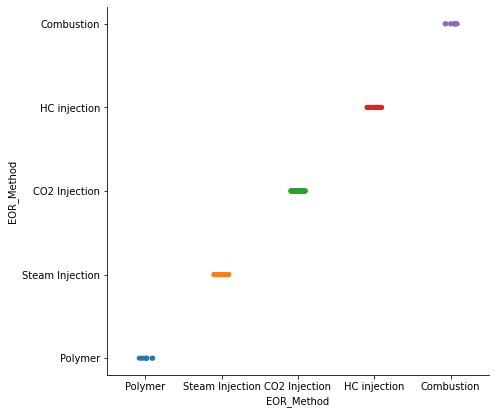

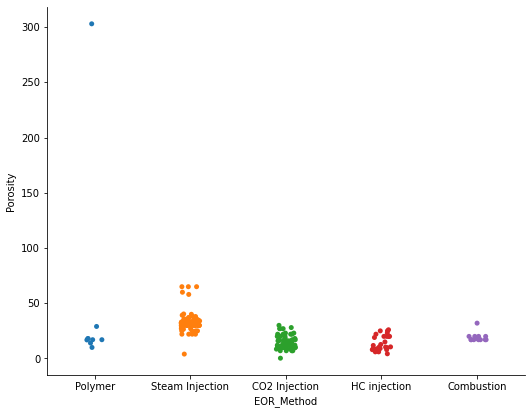

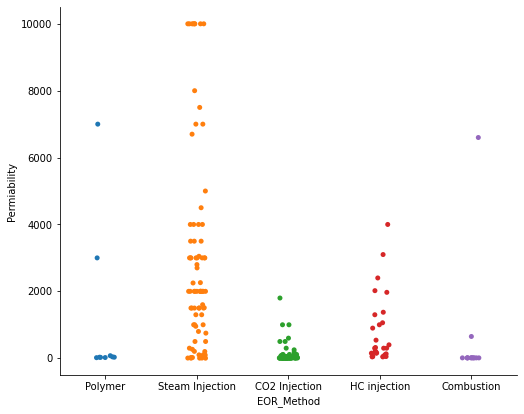

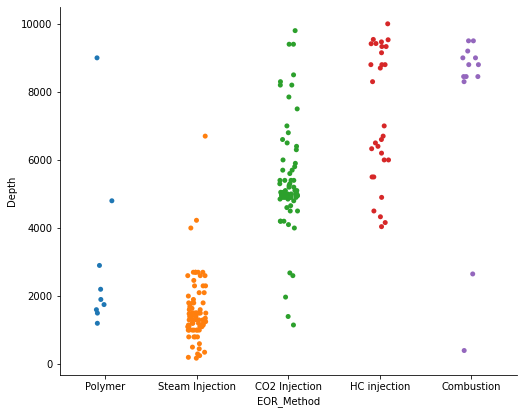

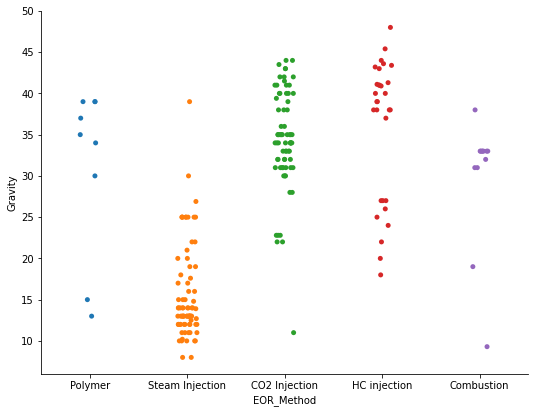

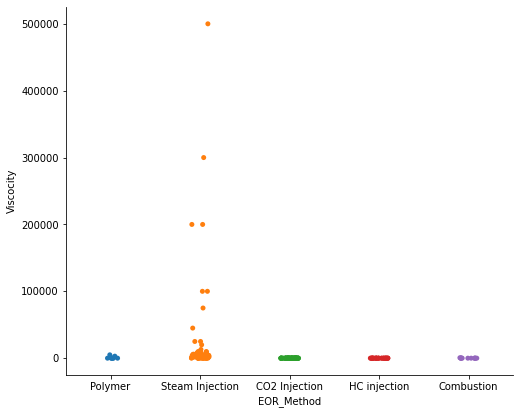

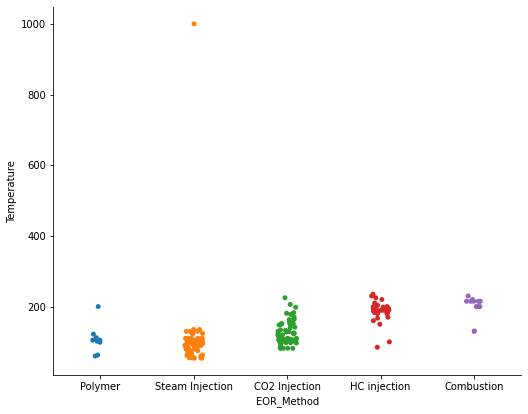

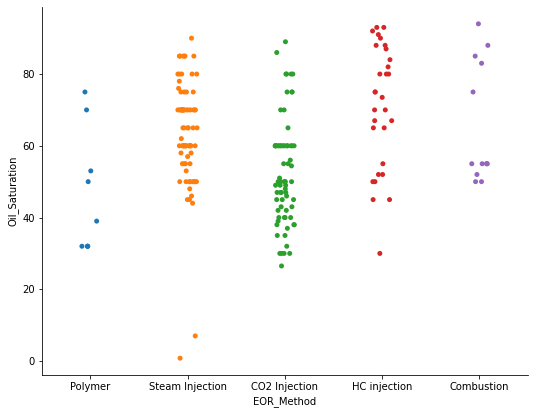

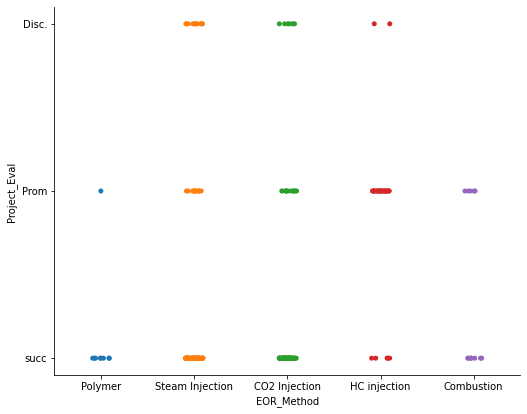

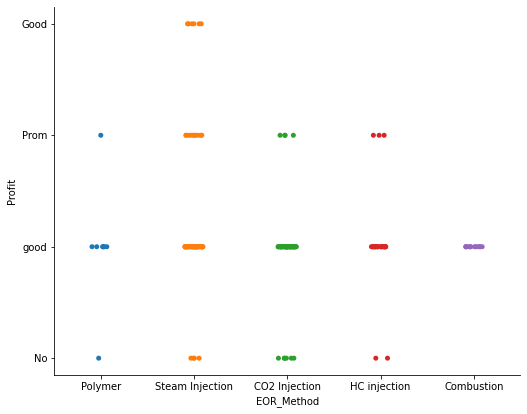

In [6]:
#plotting categorical plots
for i in dataset.columns:
    ax=sns.catplot(x="EOR_Method",y=i,data=dataset)
    ax.fig.set_size_inches(8,6)

From above plots                                                 
Steam injection for low API gravity,Shallow depths                                       
At higher temperature HC injection, Combustion                                            
For low oil saturations steam injection has been implemeted                                    
Steam Injection most widely applied method across countries

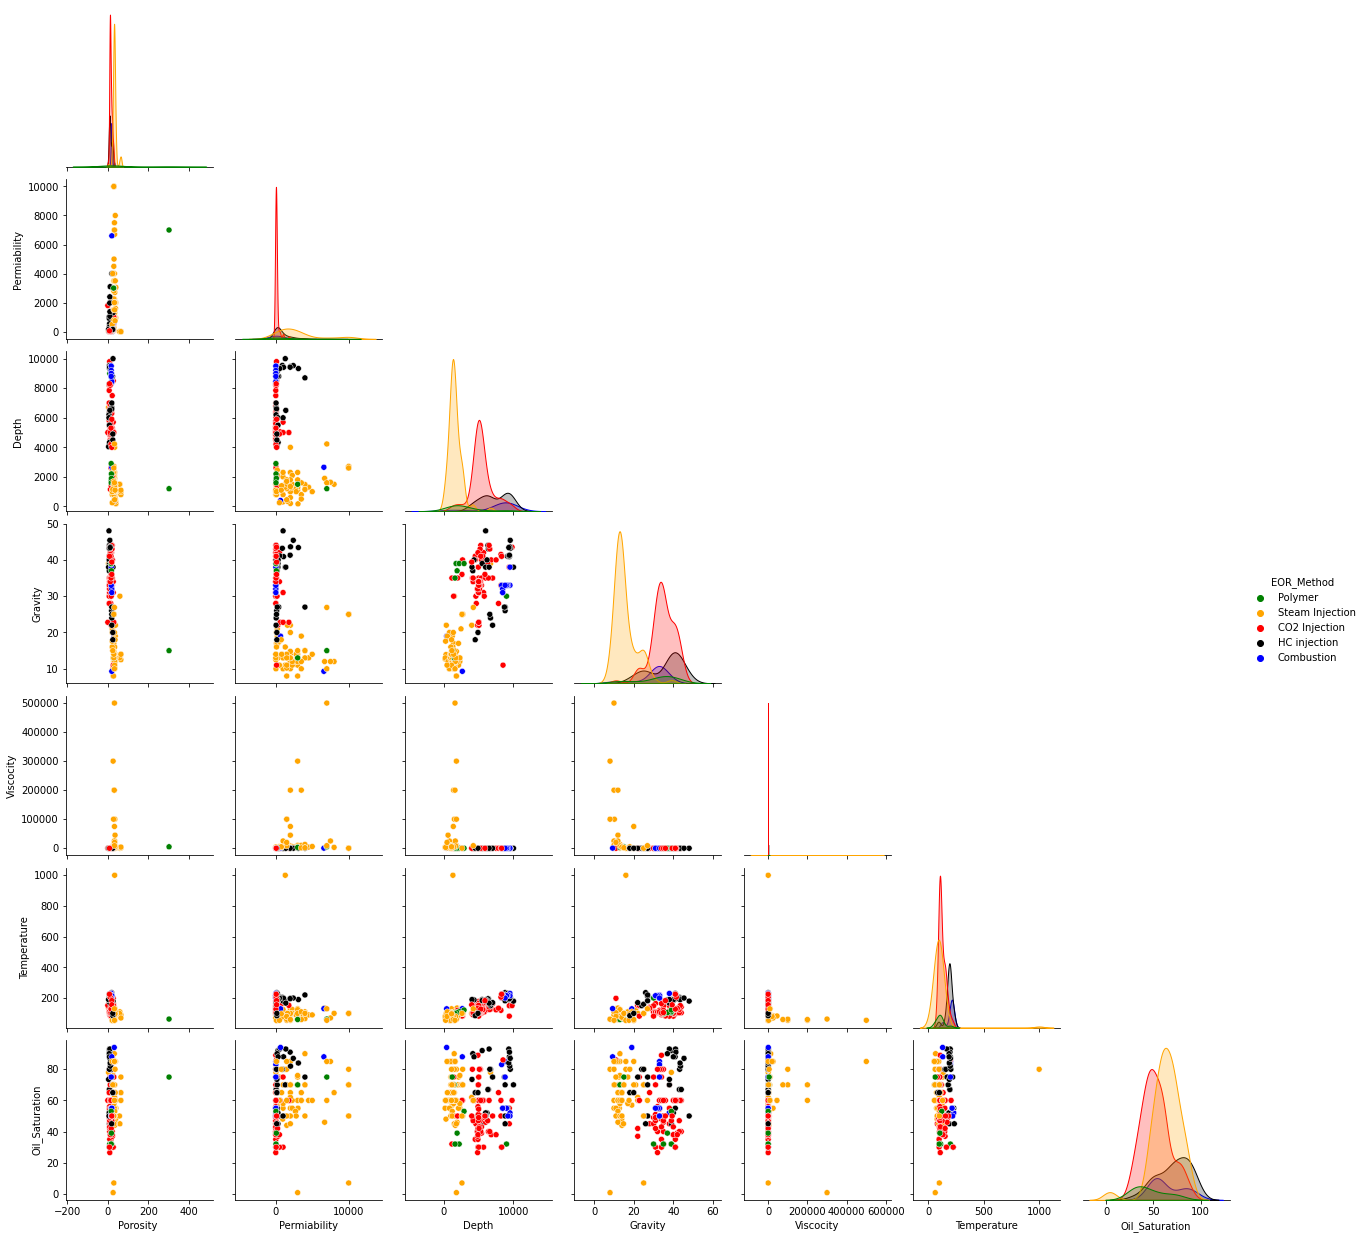

In [7]:
sns.pairplot(dataset, hue="EOR_Method",corner=True,palette=['green','orange','red','black','blue'])

From pairplots                                                
No significant correlation visible from plots except between temperature and depth                   
Some Visible Trends                                           
Oil Saturation HC>Steam>CO2 injection>Combustion>Polymer                    
Temperature Combustion>HC Injection>CO2 injection>Polymer>Steam     
Gravity HC injection->CO2 Injection->Polymer->Combustion->Steam Injection                                                                                 Depth  HC injection->Combustion->CO2 Injection->Polymer->Steam Injection

dataset.rename(columns={'Permeability':'Permiability'},inplace=True)

In [8]:
#dropping country and profit as we are evaluating successful projects
feat=dataset.iloc[:,2:9]
target=dataset.iloc[:,1]

In [9]:
#encoding EOR_Methods
from sklearn.preprocessing import LabelEncoder
target=LabelEncoder().fit_transform(target)

Encoded Class                              
Polymer-3                 
Steam Injection	-4                 
CO2 Injection-0                    
HC Injection -2                   
Combustion-1                          

<AxesSubplot:>

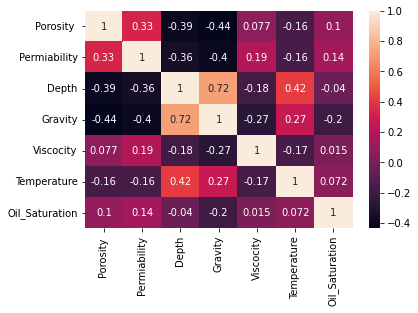

In [10]:
import seaborn as sns
sns.heatmap(feat.corr(),annot=True)

From above only significant correlation is between depth and gravity

In [11]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(feat,target,random_state=42,stratify=target,test_size=0.20)

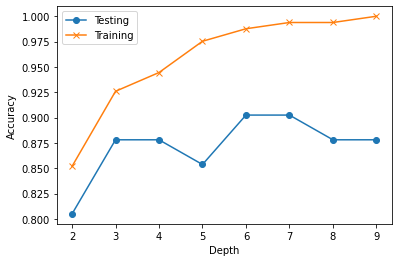

In [12]:
from sklearn.ensemble import RandomForestClassifier as rfc
x=list()
y=list()
for i in range(2,10):
    modelx=rfc(max_depth=i,random_state=0)
    modelx.fit(X_train,y_train)
    x.append(modelx.score(X_train,y_train))
    y.append(modelx.score(X_test,y_test))
plt.plot(range(2,10),y,marker='o')
plt.plot(range(2,10),x,marker='x')
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.legend(["Testing","Training"])

Depth=6 is most optimal

In [13]:
model=rfc(max_depth=6,random_state=0)
model.fit(X_train,y_train)

RandomForestClassifier(max_depth=6, random_state=0)

<BarContainer object of 7 artists>

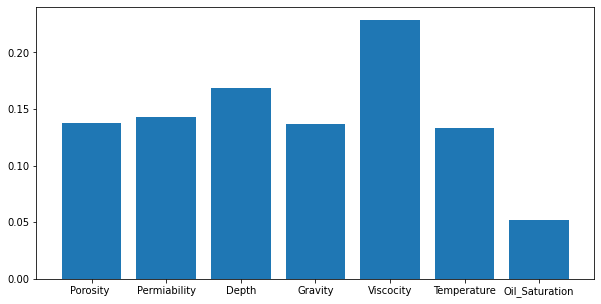

In [14]:
plt.figure(figsize=(10,5))
plt.bar(feat.columns,model.feature_importances_)

In [15]:
model.score(X_train,y_train),model.score(X_test,y_test)

(0.9876543209876543, 0.9024390243902439)

Training accuracy of 98.76% and testing accuracy of 90.24%

# Analysing through clustering

In [16]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_feat=scaler.fit_transform(feat)

Text(0, 0.5, 'WCSS')

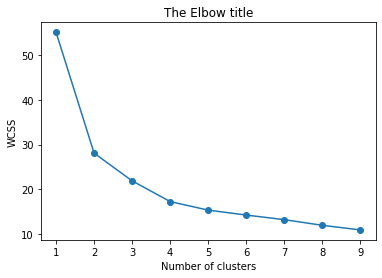

In [17]:
from sklearn.cluster import KMeans
wcss=[]
for i in range(1,10):
    kmeans = KMeans(i)
    kmeans.fit(scaled_feat)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

number_clusters = range(1,10)
plt.plot(number_clusters,wcss,marker='o')
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [18]:
kmeans2 = KMeans(5)
kmeans2.fit(scaled_feat)
ypred1=kmeans2.predict(scaled_feat)

In [19]:
l=[]
for i in ypred1:
    if i==1:
        l.append("Steam Injection")
    elif i==0:
        l.append("CO2 Injection")
    elif i==3:
        l.append("HC Injection")
    elif i==4:
        l.append("Polymer")
    else:
        l.append("Combustion")

In [20]:
feat['cluster']=l

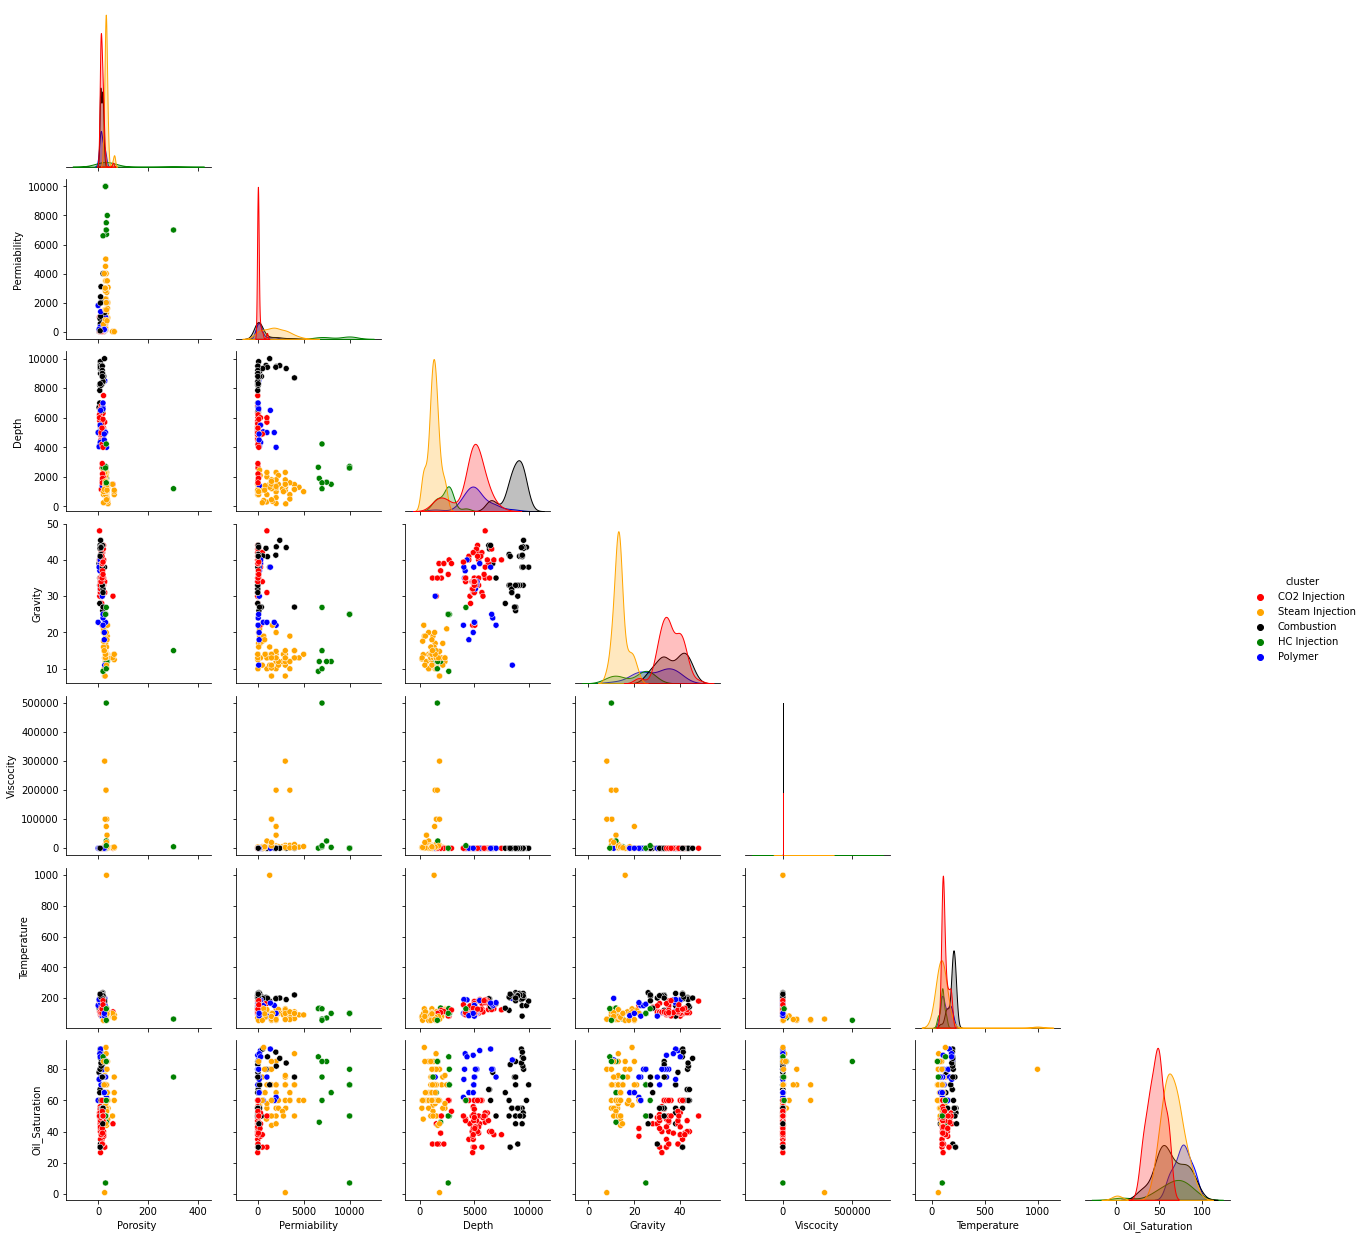

In [21]:
sns.pairplot(feat,hue='cluster',corner=True,palette=['red','orange','black','green','blue'])

More distinctive patterns compared to regression analysis

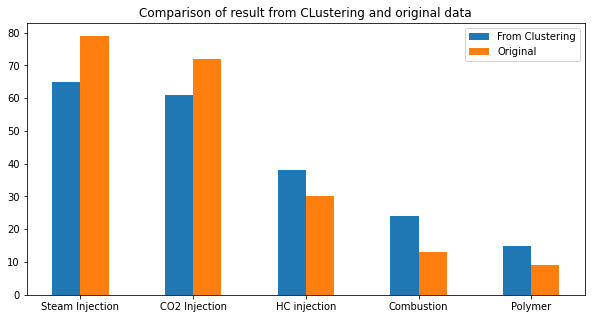

In [22]:
fig,axes=plt.subplots(figsize=(10,5))
x=np.arange(5)
barwidth=0.25
axes.bar(x,list(pd.value_counts(l)),barwidth,label="From Clustering")
axes.bar(x+barwidth,list(pd.value_counts(dataset["EOR_Method"])),barwidth,label="Original")
axes.set_xticks(x + barwidth / 2)
axes.set_xticklabels(['Steam Injection','CO2 Injection','HC injection','Combustion','Polymer'])
axes.legend()
plt.title('Comparison of result from CLustering and original data')
plt.show()